## Подготовка и визуализация данных

<div class="alert alert-block alert-warning">
<b>Структура данных.</b> Исходные данные представляют собой файлы в формате miniSEED. В каждом файле miniSEED записаны данные с трёх каналов (E, N, Z) локальной сети из $13$ сейсмостанций, для каждой пары станция+канал запись имеет длину $27000$ значений. То есть всего в каждом файле хранится $ 13 * 3 = 39$ столбцов длиной $27000$ значений. Разница во времени между соседними записями равна $0.01$ сек, так как частота дискретизации равна $100$ Гц.
</div>

1. В этом ноутбуке исходные данные из формата miniSEED конвертирую в csv;
2. Строю сейсмограммы для каждого файла.

Ссылка на [проект][] в github.


[проект]: https://github.com/KirillLavrentev/microearthquake_detection "GitHub"

### Навигация

[1. Сохраняем файлы в csv-формат](#Сохраним-все-файлы-в-csv)

[2. Строим графики](#Строим-графики)

In [1]:
from obspy.core import read
from obspy import read

import os
import pandas as pd
import datetime as dt
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


Прописываем пути к файлам.

In [2]:
OS = 'Linux' # указываем тип ОС (Linux/Windows), так как на Windows запуск немного отличается

# Путь к файлам miniSEED
path = "/home/kl/Рабочий стол/Diploma_master/data/origin_data/"

# здесь хранятся преобразованные файлы miniSEED-->csv
raw_csv_path = '/home/kl/Рабочий стол/Diploma_master/data/origin_in_csv_bandpass/'

# сюда будем сохранять графики
path_image = "/home/kl/Рабочий стол/Diploma_master/graph_images/graph_images_bandpass/"

Считываем все файлы miniSEED из директории *path*.

<div class="alert alert-block alert-info">
<b>Совет 1.</b> Пути для операционных систем Windows и Linux записываются по-разному:
 <ul>
 <li>C:\\\Users\\\User-1\\\Desktop\\\Diploma_master\\\origin_in_csv_bandpass\\\ (Windows)</li>
 <li>/home/kl/Рабочий стол/Diploma_master/data/origin_in_csv_bandpass/ (Linux)</li>
 </ul>

</div>

<div class="alert alert-block alert-info">
<b>Совет 2.</b> Для запуска этой программы необходимо установить библиотеку ObsPy.
</div>


Инструкцию по установке ObsPy можно найти [здесь][].


[здесь]: https://github.com/obspy/obspy/wiki/Installation-via-Anaconda


In [3]:
files = os.listdir(path)
files[:3]

['2016-12-13-0105-03M.arct__039',
 '2016-12-13-1515-34M.arct__039',
 '2016-12-25-0318-26M.arct__039']

### Сохраним все файлы в csv
[В начало](#Навигация)

Теперь считываем данные из файлов miniSEED, применяем к ним фильтр, и сохраняем в формат csv.


In [4]:
filt = 'bandpass' # Нужно ли как-нибудь обработать начальные данные?

station_names = []
station,time = '',''
times = [n for n in range(27000)]
data = []
dicti = {'time':times}
times = []
for file in tqdm(files):
    st = read(path + file)  # load example seismogram
    dicti.clear()
    times = [n for n in range(27000)]  # так делаем, чтобы столбец времени был первым, а не последним
    dicti = {'time':times}
    times = []
    
    for count,tr in enumerate(st):
        if (filt): # если прописан фильтр, то применяем его к данным
            tr.filter(filt, freqmin=6, freqmax=16, corners=6)

        station = str(tr.stats.station) + '.' + str(tr.stats.channel)[-1]
        station_names.append(station)

        begin = pd.Timestamp(str(tr.stats.starttime))
        time = begin
        if (count == 0): # сохраняем время траекторий только один раз
            for _ in range(len(tr)):
                time = time + pd.Timedelta(seconds = 0.01)        
                times.append(time) 
        dicti.update({station:tr.data})        
        data.append(tr.data) # сохраняем данные каждого трека
        
    dicti.update({'time' : times})
    df5 = pd.DataFrame(dicti)
    name = str(time)[:24]
    if (OS == 'Windows'):
        name = name.replace(":","_") # только для Windows делаем, т.к. папки в Windows нельзя называть с ':'
        
    df5.to_csv(raw_csv_path + name + '.csv', index=False)
    times = []
    dicti.clear()

  0%|          | 0/105 [00:00<?, ?it/s]

### Строим графики

[В начало](#Навигация)

Теперь построим графики для каждого файла. Для каждого временного промежутка построим по три графика (E, N, Z) на станцию. 

Перед визуализацией всех файлов, посмотрим, как выглядит график для одной станции.

In [5]:
files = os.listdir(raw_csv_path)

df5 = pd.read_csv(raw_csv_path + files[0])
df5['time'] = df5['time'].apply(lambda x: pd.Timestamp(x))
columns = list(df5.columns)[1:]
date = str(df5['time'][0].date())
df5.head()

,time,620.E,620.N,620.Z,621.E,621.N,621.Z,622.E,622.N,622.Z,...,629.Z,630.E,630.N,630.Z,631.E,631.N,631.Z,632.E,632.N,632.Z
0,2016-12-13 15:17:59.559900+00:00,-0.001022,0.003065,0.000341,-0.002043,0.005789,0.008173,-0.006811,0.000681,-0.005108,...,0.003405,0.004086,-0.003405,-0.002043,-0.002724,-0.008173,0.000000,-0.005449,0.004427,0.007832
1,2016-12-13 15:17:59.569900+00:00,-0.010994,0.029235,0.003324,-0.013474,0.050718,0.067175,-0.059669,0.007670,-0.045092,...,0.028813,0.036823,-0.028813,-0.017901,-0.026251,-0.078754,-0.006811,-0.049097,0.037082,0.063851
2,2016-12-13 15:17:59.579900+00:00,-0.052404,0.119967,0.013576,-0.033627,0.194043,0.234517,-0.230249,0.035422,-0.173457,...,0.105834,0.149007,-0.107196,-0.069347,-0.117547,-0.346170,-0.061031,-0.196746,0.133689,0.223325
3,2016-12-13 15:17:59.589900+00:00,-0.142621,0.264382,0.027743,-0.025392,0.397863,0.414057,-0.491502,0.084703,-0.359061,...,0.206732,0.345158,-0.223093,-0.148850,-0.317132,-0.901521,-0.246610,-0.443873,0.255918,0.404133
4,2016-12-13 15:17:59.599900+00:00,-0.226768,0.276213,0.020387,0.060510,0.346403,0.221801,-0.535237,0.090997,-0.336370,...,0.168623,0.450627,-0.256931,-0.161824,-0.541918,-1.464403,-0.579470,-0.535452,0.216885,0.256887


In [6]:
df5.shape

(27000, 40)

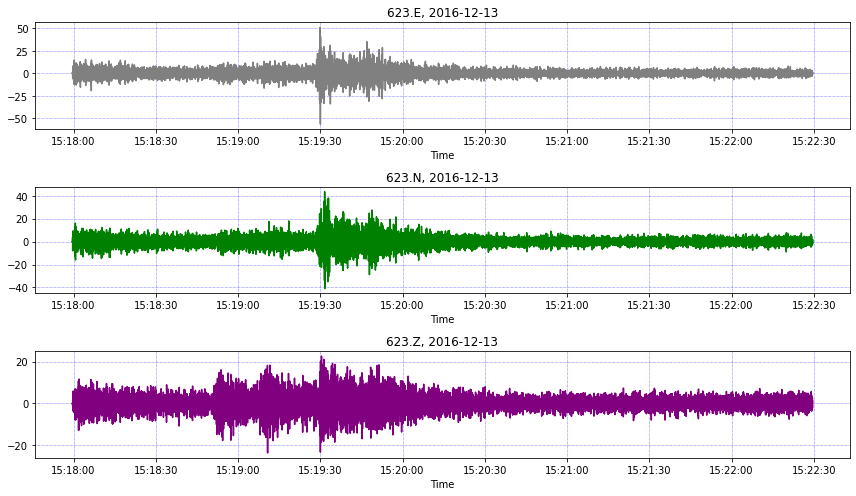

CPU times: user 6.3 s, sys: 540 ms, total: 6.84 s
Wall time: 6.01 s


In [7]:
%%time
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 7))

column = '623.E'
axs[0].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
axs[0].plot(df5['time'], np.array(df5[column]), '-',color = 'grey')
axs[0].set_xlabel('Time')
axs[0].set_title(column + ', ' + date)


column = '623.N'
axs[1].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
axs[1].plot(df5['time'], np.array(df5[column]), '-',color = 'green')
axs[1].set_xlabel('Time')
axs[1].set_title(column + ', ' + date)


column = '623.Z'
axs[2].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
axs[2].plot(df5['time'], np.array(df5[column]), '-',color = 'purple')
axs[2].set_xlabel('Time')
axs[2].set_title(column + ', ' + date)


plt.tight_layout()
plt.show()


Убеждаемся, что тестовый график выглядит как нужно. Теперь можно в цикле построить графики для всех станций. 

In [8]:
files = os.listdir(raw_csv_path)
a = 100 #files.index()
files_count = 0

for file in tqdm(files[a:]):
    files_count += 1
    df5 = pd.read_csv(raw_csv_path + file)
    df5['time'] = df5['time'].apply(lambda x: pd.Timestamp(x))
    columns = list(df5.columns)[1:]
    date = str(df5['time'][0].date())
    
    for three_cols in range(0,len(columns),3):
        fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 7))

        column = columns[three_cols]
        axs[0].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
        axs[0].plot(df5['time'], np.array(df5[column]), '-',color = 'grey')
        axs[0].set_xlabel('Time')
        axs[0].set_title(column + ', ' + date)


        column = columns[three_cols+1]
        axs[1].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
        axs[1].plot(df5['time'], np.array(df5[column]), '-',color = 'green')
        axs[1].set_xlabel('Time')
        axs[1].set_title(column + ', ' + date)


        column = columns[three_cols+2]
        axs[2].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
        axs[2].plot(df5['time'], np.array(df5[column]), '-',color = 'purple')
        axs[2].set_xlabel('Time')
        axs[2].set_title(column + ', ' + date)


        plt.tight_layout()
        
        if (OS == 'Windows'):
            directory = str(df5['time'][0]) + "\\" # для Windows '\\'
            directory = directory.replace(":","_") # только для Windows делаем, т.к. папки в Windows нельзя называть с ':'
        else:
            directory = str(df5['time'][0]) + "/" # для Linux '/'
        
        path2 = os.path.join(path_image,directory)
        try: 
            os.makedirs(path2) 
        except OSError as error: 
            pass
        
        
        fig.savefig(path2 + '{}.jpeg'.format(column[:3]),dpi=100)
        plt.cla()
        plt.clf()
        fig.clf()
        plt.close('all')
        plt.close(fig)
        plt.close()

    plt.cla()
    plt.clf()
    fig.clf()
    plt.close('all')
    plt.close(fig)
    plt.close()
    
    print('Уже загрузили {} файлов.'.format(files.index(file)))
    print('Осталось загрузить ещё {} файлов.\n'.format(len(files)-files.index(file)))


  0%|          | 0/5 [00:00<?, ?it/s]

Уже загрузили 100 файлов.
Осталось загрузить ещё 5 файлов.

Уже загрузили 101 файлов.
Осталось загрузить ещё 4 файлов.

Уже загрузили 102 файлов.
Осталось загрузить ещё 3 файлов.

Уже загрузили 103 файлов.
Осталось загрузить ещё 2 файлов.

Уже загрузили 104 файлов.
Осталось загрузить ещё 1 файлов.



In [9]:
print('Построенные графики можно посмотреть в директории:\n',path_image)

Построенные графики можно посмотреть в директории:
 /home/kl/Рабочий стол/Diploma_master/graph_images/graph_images_bandpass/


[В начало](#Подготовка-и-визуализация-данных)

<div class="alert alert-block alert-success">
<b>Результат работы программы.</b> 
<ol>
 <li>Считали исходные данные формата miniSEED, разобрались в их структуре. </li>
 <li>Конвертировали данные из miniSEED в csv-формат. </li>
 <li>Построили графики для каждой станции из каждого файла, сохранили эти графики в папки.</li>
</ol>
</div>

- [x] Подготовить данные для работы, перевести их в формат csv
- [x] Визуализировать данные
- [ ] Разметить файлы, опираясь на их визуализацию
- [ ] Объединить файлы в датафрейм
- [ ] Обучить модели, выявить лучшую
- [ ] Протестировать модель, дать оценку